In [2]:
import numpy as np
import sklearn
from scipy.stats.stats import pearsonr
import pickle
import pandas as pd
from scipy.cluster.vq import whiten
from sklearn import cluster
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt
import urllib
from numpy import isnan, nan, logical_not, logical_or
import tensorflow as tf
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from numpy import genfromtxt
from random import shuffle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14074724032920408977
]


# Get the data

In [2]:
Count_full = np.array([22310,  3960,  3500,  1770,  3172,  3710,  2390,  1470,  1230,
        2150,  2380,  5722,  1924,  1920,  3532,  2600,  2264,  6910,
        6520,  4344,  1310,  1150,  2714,  2380,  2712,  6224,  2318,
        2636,  2646,  1410,  1410,  2950,  1410,  1100,  1240,  1310,
        1580,  1790,  1724,  2042,  1860,  1010,  1528,  5462,  5720,
        2778,  1408,  6330,  2040,  4960,  1660,  1570,  1450,  1090,
        4632,  1438,  1418,  3300,  1220,  3624,  1400,  1524,  1160,
        3486,  2030,  2200,  2694,  5750,  1522,  1950,  1280,  1910,  5834])

In [3]:
length_folders = np.array([10, 13, 20, 14, 16])

In [53]:
full_data_x = pickle.load(open("Full_data_x.p", "rb" ))
print(full_data_x.shape)
full_data_x = np.reshape(full_data_x, (full_data_x.shape[0],full_data_x.shape[1]*full_data_x.shape[2]))
print(full_data_x.shape)

(213072, 68, 2)
(213072, 136)


In [50]:
data_x = pickle.load( open( "data_x.p", "rb" ))
print(data_x.shape)

(106536, 196)


In [5]:
annotation_vector_Two = pickle.load( open( "annotation_vector_Two.p", "rb" ))
print(annotation_vector_Two.shape)

(73,)


# Scale the data

In [6]:
# get the participants separated

from sklearn import preprocessing

data_participant1 = data_x[:,:98]
data_participant2 = data_x[:,98:]
participant1_scaled = preprocessing.scale(data_participant1)
participant2_scaled = preprocessing.scale(data_participant2)
data_x = preprocessing.scale(data_x)

C:\Users\pinouche\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype <U7 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# Smooth the response data

In [7]:
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

def SmoothResponse(response_list = annotation_vector_Two):
    length = len(annotation_vector_Two)
    gauss_kernel_40 = Gaussian1DKernel(25)
    gauss_kernel_50 = Gaussian1DKernel(50)
    gauss_kernel_75 = Gaussian1DKernel(75)
    gauss_kernel_100 = Gaussian1DKernel(100)
    annotation_RBF40 = []
    annotation_RBF50 = []
    annotation_RBF75 = []
    annotation_RBF100 = []
    for index in range(length):
        response_list[index] = np.reshape(response_list[index], (response_list[index].shape[0],))
        
        Ann40 = convolve(response_list[index], gauss_kernel_40)
        Ann40[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann40 = np.reshape(Ann40, (response_list[index].shape[0],1))
        
        Ann50 = convolve(response_list[index], gauss_kernel_50)
        Ann50[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann50 = np.reshape(Ann50, (response_list[index].shape[0],1))
        
        Ann75 = convolve(response_list[index], gauss_kernel_75)
        Ann75[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann75 = np.reshape(Ann75, (response_list[index].shape[0],1))
        
        Ann100 = convolve(response_list[index], gauss_kernel_100)
        Ann100[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann100 = np.reshape(Ann100, (response_list[index].shape[0],1))
    
        annotation_RBF40.append(Ann40)
        annotation_RBF50.append(Ann50)
        annotation_RBF75.append(Ann75)
        annotation_RBF100.append(Ann100)
           
    return annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 

In [8]:
annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 = SmoothResponse()
print([len(annotation_RBF40), len(annotation_RBF50), len(annotation_RBF75), len(annotation_RBF100)])
print([annotation_RBF40[0].shape, annotation_RBF50[0].shape, annotation_RBF75[0].shape, annotation_RBF100[0].shape])

[73, 73, 73, 73]
[(11155, 1), (11155, 1), (11155, 1), (11155, 1)]


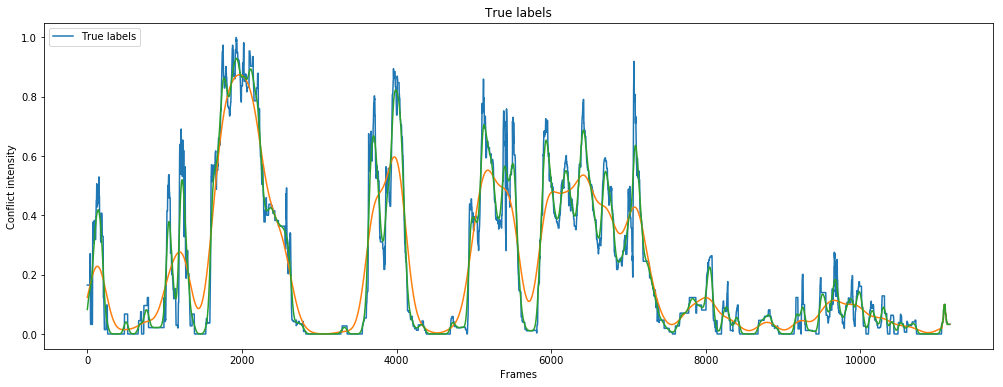

In [9]:
# Plot a few video sequences to see if smoothing is justified

fig = plt.figure(figsize=(17, 6))
plt.plot(annotation_vector_Two[0])
plt.plot(annotation_RBF100[0])
plt.plot(annotation_RBF40[0])
plt.title('True labels')
plt.ylabel('Conflict intensity')
plt.xlabel('Frames')
plt.legend(['True labels'], loc='upper left')
plt.show()

# Prepare data to be fed

In [10]:
def Makelist(data,Count):
    Count = Count/2
    list_data = []
    ball = 0
    for index in range(0,len(Count)):
        list_data.append(data[ball:(ball+int(Count[index])),:])
        ball += int(Count[index])
    return(np.asarray(list_data))

In [11]:
list_data_x = Makelist(data_x, Count_full)

In [13]:
# put the things into FOLDS

def DoFOLDS(list_data, annotation_list_smooth, annotation_list, num_folder1=length_folders[0], num_folder2=length_folders[1], num_folder3=length_folders[2], num_folder4=length_folders[3], num_folder5=length_folders[4]):
    Fold1 = []
    Fold2 = []
    Fold3 = []
    Fold4 = []
    Fold5 = []
    Fold1_y_smooth = []
    Fold2_y_smooth = []
    Fold3_y_smooth = []
    Fold4_y_smooth = []
    Fold5_y_smooth = []
    Fold1_y = []
    Fold2_y = []
    Fold3_y = []
    Fold4_y = []
    Fold5_y = []
    
    for index in range(num_folder1):
        Fold1.append(list_data[index])
        Fold1_y_smooth.append(annotation_list_smooth[index])
        Fold1_y.append(annotation_list[index])
    for index in range(num_folder1, num_folder1+num_folder2):
        Fold2.append(list_data[index])
        Fold2_y_smooth.append(annotation_list_smooth[index])
        Fold2_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2,num_folder1+num_folder2+num_folder3):
        Fold3.append(list_data[index])
        Fold3_y_smooth.append(annotation_list_smooth[index])
        Fold3_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2+num_folder3,num_folder1+num_folder2+num_folder3+num_folder4):
        Fold4.append(list_data[index])
        Fold4_y.append(annotation_list[index])
        Fold4_y_smooth.append(annotation_list_smooth[index])
    for index in range(num_folder1+num_folder2+num_folder3+num_folder4,num_folder1+num_folder2+num_folder3+num_folder4+num_folder5):
        Fold5.append(list_data[index])
        Fold5_y_smooth.append(annotation_list_smooth[index])
        Fold5_y.append(annotation_list[index])
    
    assert (len(Fold1)+len(Fold2)+len(Fold3)+len(Fold4)+len(Fold5)) == 73
    
    return Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y

Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y = DoFOLDS(list_data_x, annotation_RBF40, annotation_vector_Two)

In [14]:
#Test number must be either 1,2,3,4,5

def MakeTrainValTest(test_number, Fold1=Fold1, Fold2=Fold2, Fold3=Fold3, Fold4=Fold4, Fold5=Fold5, Fold1_y=Fold1_y, Fold2_y=Fold2_y, Fold3_y=Fold3_y, Fold4_y=Fold4_y, Fold5_y=Fold5_y, Fold1_y_smooth=Fold1_y_smooth, Fold2_y_smooth=Fold2_y_smooth, Fold3_y_smooth=Fold3_y_smooth, Fold4_y_smooth=Fold4_y_smooth, Fold5_y_smooth=Fold5_y_smooth):
    list_Folds = list([Fold1, Fold2, Fold3, Fold4, Fold5])
    list_Folds_y = list([Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y])
    list_Folds_y_smooth = list([Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth])
    number_val_test = []
    Train_list = []
    Val_list = []
    Test_list = []
    Train_list_y = []
    Val_list_y = []
    Test_list_y = []
    length = 0
    
    Test_list = list_Folds[test_number-1]
    Test_list_y = list_Folds_y[test_number-1]
    number_val_test.append(test_number-1)
    
    if(test_number == 1):
        Val_list = list_Folds[4]
        Val_list_y = list_Folds_y[4]
        number_val_test.append(4)
    else:
        Val_list = list_Folds[test_number-2]
        Val_list_y = list_Folds_y[test_number-2]
        number_val_test.append(test_number-2)
    
    for index in range(5):
        length = len(list_Folds[index])
        if(index != number_val_test[0] and index != number_val_test[1]):
            for index2 in range(length):
                Train_list.append(list_Folds[index][index2])
                Train_list_y.append(list_Folds_y_smooth[index][index2])       
    
    return Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y 

In [15]:
Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(1)

In [374]:
# Make the Val_list_y of interest from above in 2 classes (low, medium, high) of conflict

def MakeOneHot(val_list_y):
    new_list = []
    a = np.array([1,0])
    b = np.array([0,1])
    #c = np.array([0,0,1])
    for index in range(len(val_list_y)):
        for element in val_list_y[index]:
            if(element <= 0.5):
                new_list.append(a)
            if(element > 0.5):
                new_list.append(b)
            #elif(element >= 2/3):
            #    new_list.append(c)
    return(new_list)

In [17]:
# function to compute the class accuracy

def ComputeAccuracy(True_classes_list, predicted_classes_list):
    accuracy = 0
    assert len(True_classes_list) == len(predicted_classes_list)
    for index in range(len(True_classes_list)):
        if(all (True_classes_list[index] == predicted_classes_list[index])):
            accuracy += 1
    accuracy /= len(predicted_classes_list)
    return(accuracy)

In [18]:
def MakeOneHotTrain(train_list_y):
    new_list = []
    final_list = []
    a = np.array([1,0,0])
    b = np.array([0,1,0])
    c = np.array([0,0,1])
    length = 0
    count = 0
    for index in range(len(train_list_y)):
        length = len(train_list_y[index])
        for element in train_list_y[index]:
            if(element < 1/3):
                new_list.append(a)
            elif(element >= 1/3 and element < 2/3):
                new_list.append(b)
            elif(element >= 2/3):
                new_list.append(c)
        final_list.append(np.asarray(new_list[count:count+length]))
        count += length
    return(final_list)

In [19]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def SoftMaxFlatten(crocker):
    finalList=[]
    for element in crocker:
        for sub_element in element:
            smax=softmax(sub_element)
            b = np.zeros_like(smax)
            b[np.where(smax==np.max(smax))] = 1
            finalList.append(b)
            
    return finalList

In [425]:
def PearsonCor(pred_val_list, val_list_y):
    pearson_cor = 0
    assert len(pred_val_list) == len(val_list_y)
    for index in range(len(pred_val_list)):
        pearson_cor += pearsonr(np.reshape(pred_val_list[index], (pred_val_list[index].shape[0],)), np.reshape(val_list_y[index], (val_list_y[index].shape[0],)))[0]
    return(pearson_cor/len(pred_val_list)) 

In [22]:
def exclude_nan(x,y):

    idx = logical_not(logical_or(isnan(x), isnan(y)))
    x = x[idx]
    y = y[idx]
    n = len(x)
    return [x, y, n]

def compute_icc(x, y):

    if all(x == y):
        return 1

    [x, y, n] = exclude_nan(x,y)

    ## Need at least 3 data points to compute this
    if n < 3:
        return nan

    Sx = sum(x); Sy = sum(y);
    Sxx = sum(x*x); Sxy = sum( (x+y)**2 )/2; Syy = sum(y*y)

    fact = ((Sx + Sy)**2)/(n*2)
    SS_tot = Sxx + Syy - fact
    SS_among = Sxy - fact
    SS_error = SS_tot - SS_among

    MS_error = SS_error/n
    MS_among = SS_among/(n-1)

    ICC = (MS_among - MS_error) / (MS_among + MS_error)

    return ICC

# Bidirectional LSTM encoder

In [883]:
timesteps_1 = 2
window_size = 50
batch_size = window_size
n_epochs = 10

# Hidden layer for the LSTMs
hidden_size_bilstm = 64
hidden_size_mainlstm = 64

# Hidden size for the fully connected layer
FC1 = 32

num_input = 98
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

In [887]:
def BidirectionalLSTM(train_x, train_y, val_x, val_y,hidden_size_bilstm=hidden_size_bilstm, hidden_size_mainlstm=hidden_size_mainlstm, batch_size = batch_size,  n_epochs=n_epochs, epsilon = epsilon, learning_rate=learning_rate):
    
    
    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [window_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")

    #Bidirectional lstm with different weights
    #with tf.variable_scope('lstm_cell_forward'):
    #    lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    #with tf.variable_scope('lstm_cell_backward'):
    #    lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    # Bidirectional lstm with shared weights (makes more sense for them to be shared)
    with tf.variable_scope('lstm_cell_bidirectional'):
        lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    with tf.variable_scope('lstm_cell_bidirectional', reuse=True):
        lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    with tf.variable_scope("lstm_bidirectional"):
        bi_outputs, _, _ = tf.nn.static_bidirectional_rnn(lstm_cell_f, lstm_cell_b, inputs = X, dtype= tf.float32)
        last_output = bi_outputs[-1]
        
        
        batch_mean2, batch_var2 = tf.nn.moments(last_output,[0])
        scale2 = tf.Variable(tf.ones([hidden_size_bilstm*2]))
        beta2 = tf.Variable(tf.zeros([hidden_size_bilstm*2]))
        BN2 = tf.nn.batch_normalization(last_output,batch_mean2, batch_var2, beta2, scale2, epsilon) 
        BN2 = tf.nn.dropout(BN2, prob)
        
        BN2 = tf.reshape(BN2, (1, window_size, hidden_size_bilstm*2))
        BN2 = tf.transpose(BN2, [1, 0, 2])
        BN2 = tf.unstack(BN2)
    
    with tf.variable_scope('lstm_cell_2'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size_mainlstm, hidden_size_mainlstm]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs2, lstm_state2 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=BN2,dtype=tf.float32)
        lstm_outputs2 = tf.stack(tf.squeeze(lstm_outputs2))
        
        batch_mean3, batch_var3 = tf.nn.moments(lstm_outputs2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size_mainlstm]))
        beta3 = tf.Variable(tf.zeros([hidden_size_mainlstm]))
        BN3 = tf.nn.batch_normalization(lstm_outputs2,batch_mean3, batch_var3, beta3, scale3, epsilon) 
        BN3 = tf.nn.dropout(BN3, prob)
        
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size_mainlstm, FC1], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN3, W_hidden)
        
        batch_mean4, batch_var4 = tf.nn.moments(hidden_relu,[0])
        scale4 = tf.Variable(tf.ones([FC1]))
        beta4 = tf.Variable(tf.zeros([FC1]))
        BN4 = tf.nn.batch_normalization(hidden_relu,batch_mean4, batch_var4, beta4, scale4, epsilon)
        BN4 = tf.nn.relu(BN4, name = "ReLu_hidden_layer")
        
    
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [FC1, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias_hidden2", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN4, W_hidden2)+b_hidden_2)
        logits_all = tf.matmul(BN4, W_hidden2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("bias_hidden2" in tf_var.name))
        loss += l2

    
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    #saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (window_size, 2, num_input))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
              
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (window_size, 2, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
   
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            ICC = compute_icc(np.asarray(pred_val), np.asarray(list_list_val_y))
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            print("The ICC(1,3) is: " + str(ICC))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y

In [889]:
# RUN THE ABOVE

#lowest_loss_list = []

#for index in range(5):
#    Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(index+1)
#    lowest_loss, min_index, loss, predictions_val, predictions_train = NeuralNetMethod1(Train_list, Train_list_y, Val_list, Val_list_y, 0.0001, 196,64, 16)
#    lowest_loss_list.append(lowest_loss)

lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y = BidirectionalLSTM(Train_list, Train_list_y, Val_list, Val_list_y)

In [890]:
tf.reset_default_graph()

In [ ]:
# Compute the correlation 

pearsonr(np.reshape(np.asarray(pred_val), (len(pred_val),)), np.reshape(np.asarray(list_list_val_y),(len(pred_val),)))

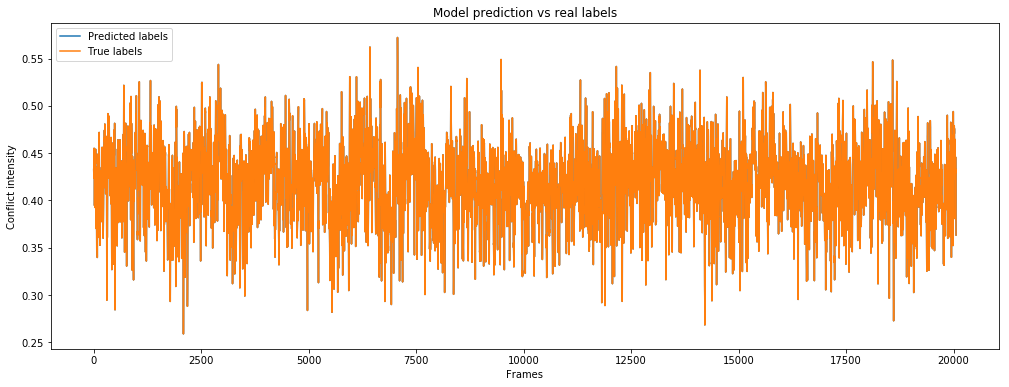

In [462]:
# function to plot true vs predicted

def plotTrueVPred(true_values, predicted_values):
    fig = plt.figure(figsize=(17, 6))
    plt.plot(predicted_values)
    plt.plot(true_values)
    plt.title('Model prediction vs real labels')
    plt.ylabel('Conflict intensity')
    plt.xlabel('Frames')
    plt.legend(['Predicted labels', 'True labels'], loc='upper left')
    plt.show()
    #fig.savefig('newfiguseless.png', bbox_inches='tight')
    
plotTrueVPred(pred_val, pred_val)

# LSTM encoder

In [346]:
def ManyToOne(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[window_size-1+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled  

In [347]:
def ManyToMany(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[index:window_size+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled 

In [348]:
epsilon = 0.001
LSTM1 = 128
LSTM2 = 128
FCL = 64

hidden_size = LSTM1
hidden_size1 = LSTM2
LSTM2 = hidden_size_mainlstm
hidden_size2 = FCL

learning_rate = 0.000001
beta = 0.02

n_epochs = 10

# Network Parameters particular to the LSTM. We feed the person 1 and then the person 2

num_input1 = 98 # num_of_features
timesteps_1 = 2 # timesteps for the first LSTM = number of participants
window_size = 50 # timesteps for the second LSTM = number of frames
timesteps_2 = window_size
batch_size = timesteps_2

In [349]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input1=num_input1, timesteps_1=timesteps_1, timesteps_2=timesteps_2):

    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input1], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")

    with tf.variable_scope('lstm_cell_1'):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_size, forget_bias = 1.0)
        lstm_outputs, lstm_states = tf.contrib.rnn.static_rnn(lstm_cell, X, dtype = tf.float32)
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs[-1],[0])
        scale1 = tf.Variable(tf.ones([hidden_size]))
        beta1 = tf.Variable(tf.zeros([hidden_size]))
        BN1 = tf.nn.batch_normalization(lstm_outputs[-1],batch_mean1, batch_var1, beta1, scale1, epsilon)
        BN1 = tf.nn.dropout(BN1, prob)
        
        BN1 = tf.reshape(BN1, [1, timesteps_2, hidden_size])
        BN1 = tf.unstack(BN1, timesteps_2, 1)
        
    ################## THIS IS THE ADDED PART
    
    with tf.variable_scope('lstm_cell_2'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size_mainlstm, hidden_size_mainlstm]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs2, lstm_state2 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=BN1,dtype=tf.float32)
        lstm_outputs2 = tf.stack(tf.squeeze(lstm_outputs2))
        
        batch_mean3, batch_var3 = tf.nn.moments(lstm_outputs2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size_mainlstm]))
        beta3 = tf.Variable(tf.zeros([hidden_size_mainlstm]))
        BN3 = tf.nn.batch_normalization(lstm_outputs2,batch_mean3, batch_var3, beta3, scale3, epsilon) 
        BN3 = tf.nn.dropout(BN3, prob)
        
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size_mainlstm, FC1], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN3, W_hidden)
        
        batch_mean4, batch_var4 = tf.nn.moments(hidden_relu,[0])
        scale4 = tf.Variable(tf.ones([FC1]))
        beta4 = tf.Variable(tf.zeros([FC1]))
        BN4 = tf.nn.batch_normalization(hidden_relu,batch_mean4, batch_var4, beta4, scale4, epsilon)
        BN4 = tf.nn.relu(BN4, name = "ReLu_hidden_layer")
        
    
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [FC1, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias_hidden2", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN4, W_hidden2)+b_hidden_2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        reg1 = tf.norm(W_hidden, ord = 2)
        reg2 = tf.norm(W_hidden2, ord = 2)
        reg3 = tf.norm(W_all, ord = 2)
        loss += beta*(reg1+reg2+reg3)
    
    for element in tf.trainable_variables():
        print(element.name)
  
    
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    #saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (window_size, 2, num_input1))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 0.7})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
              
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (window_size, 2, num_input1))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
   
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, val_loss, train_loss_list, pred_val

In [350]:
lowest_loss, min_index, val_loss, train_loss_list, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

lstm_cell_1/rnn/basic_lstm_cell/kernel:0
lstm_cell_1/rnn/basic_lstm_cell/bias:0
lstm_cell_1/Variable:0
lstm_cell_1/Variable_1:0
lstm_cell_2/rnn/multi_rnn_cell/cell_0/lstm_cell/kernel:0
lstm_cell_2/rnn/multi_rnn_cell/cell_0/lstm_cell/bias:0
lstm_cell_2/rnn/multi_rnn_cell/cell_1/lstm_cell/kernel:0
lstm_cell_2/rnn/multi_rnn_cell/cell_1/lstm_cell/bias:0
lstm_cell_2/Variable:0
lstm_cell_2/Variable_1:0
Fully_connected_Layer1/weights_hidden:0
Fully_connected_Layer1/Variable:0
Fully_connected_Layer1/Variable_1:0
loss/linear_layer:0
loss/bias_hidden2:0
loss/linear_others:0
Epoch 1 done.
Step: 1 MSE val loss is 0.135797197541 MSE training loss 0.324742148347
The total of good classification is: 0.2974870281819107
Epoch 2 done.
Step: 2 MSE val loss is 0.105539825283 MSE training loss 0.10413794805
The total of good classification is: 0.34362600468002846
Epoch 3 done.
Step: 3 MSE val loss is 0.0875023927053 MSE training loss 0.0893340711575
The total of good classification is: 0.32276935598738427


# FCL layer encoder

In [30]:
timesteps_1 = 25
window_size = timesteps_1
batch_size = window_size
n_epochs = 10

size_encoder = 128
# Hidden layer for the LSTMs
LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32


num_input = 196
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

In [31]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, size_encoder = size_encoder, hidden_size = LSTM1, hidden_size1 = LSTM2, hidden_size2 = FC1):


    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X = tf.placeholder(shape = [window_size, num_input], dtype = tf.float32, name = "input")
        #X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        #X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")
        
    
    with tf.variable_scope('Fully_connected_encoder'):
        W_input_encoder = tf.Variable(tf.random_normal(shape = [num_input, size_encoder], stddev = 0.1), name = "weights_input", trainable = True)
        hidden_units_encoder = tf.matmul(X, W_input_encoder)
        batch_mean_encoder, batch_var_encoder = tf.nn.moments(hidden_units_encoder,[0])
        scale_encoder = tf.Variable(tf.ones([size_encoder]), trainable = True)
        beta_encoder = tf.Variable(tf.zeros([size_encoder]), trainable = True)
        BN_encoder = tf.nn.batch_normalization(hidden_units_encoder,batch_mean_encoder, batch_var_encoder, beta_encoder, scale_encoder, epsilon)
        relu_hidden_encoder = tf.nn.relu(BN_encoder, name = "ReLu_hidden_encoder")
        relu_hidden_encoder = tf.reshape(relu_hidden_encoder, (1, window_size, size_encoder))
        relu_hidden_encoder = tf.unstack(relu_hidden_encoder, window_size, 1)
        
        
    with tf.variable_scope('lstm_cell_2'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size_mainlstm, hidden_size_mainlstm]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs2, lstm_state2 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=relu_hidden_encoder,dtype=tf.float32)
        lstm_outputs2 = tf.stack(tf.squeeze(lstm_outputs2))
        
        batch_mean3, batch_var3 = tf.nn.moments(lstm_outputs2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size_mainlstm]))
        beta3 = tf.Variable(tf.zeros([hidden_size_mainlstm]))
        BN3 = tf.nn.batch_normalization(lstm_outputs2,batch_mean3, batch_var3, beta3, scale3, epsilon) 
        BN3 = tf.nn.dropout(BN3, prob)
        
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size_mainlstm, FC1], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN3, W_hidden)
        
        batch_mean4, batch_var4 = tf.nn.moments(hidden_relu,[0])
        scale4 = tf.Variable(tf.ones([FC1]))
        beta4 = tf.Variable(tf.zeros([FC1]))
        BN4 = tf.nn.batch_normalization(hidden_relu,batch_mean4, batch_var4, beta4, scale4, epsilon)
        BN4 = tf.nn.relu(BN4, name = "ReLu_hidden_layer")
        
    
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [FC1, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias_hidden2", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN4, W_hidden2)+b_hidden_2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name))
        loss += l2

    
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    #saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = list_x[index]
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X: X_batch, y: Y_batch, alpha: 2, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
              
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = list_x_val[index1]
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
   
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, val_loss, train_loss_list, pred_val

In [ ]:
lowest_loss, min_index, total_loss, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

In [370]:
tf.reset_default_graph()

# CNN encoder

In [371]:
#FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_integer('window_size', 2, "Number of timesteps")
#tf.app.flags.DEFINE_integer('batch_size', 2, "Number of batches")
#tf.app.flags.DEFINE_integer('n_epochs', 10, "Number of epochs")
#tf.app.flags.DEFINE_integer('LSTM1_size', 64, "Size of lstm1")
#tf.app.flags.DEFINE_integer('LSTM2_size', 64, "Size of lstm2")
#tf.app.flags.DEFINE_integer('FCL_size', 32, "Size of FCL")

window_size = 50
batch_size = window_size
n_epochs = 10

# Hidden layer for the LSTMs
LSTM1 = 96
LSTM2 = 96
# Hidden size for the fully connected layer
FC1 = 32

# conv_net parameters

num_filter1 = 32
num_filter2 = 2

num_participants = 2
num_input = 98
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

In [372]:
def CNNencoder(train_x, train_y, val_x, val_y,hidden_size_bilstm=hidden_size_bilstm, hidden_size_mainlstm=hidden_size_mainlstm, batch_size = batch_size,  n_epochs=n_epochs, epsilon = epsilon, learning_rate=learning_rate):
    
    
    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X = tf.placeholder(shape=[window_size, num_input, num_participants, 1], dtype = tf.float32, name = "input")
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")
    
    with tf.variable_scope("Convolution_layer1"):
        conv1 = tf.layers.conv2d(inputs=X,filters=num_filter1, kernel_size=[2, 2], strides=(2, 2),padding="valid",activation=tf.nn.relu)
        conv1 = tf.transpose(conv1, [0,1,3,2])
        
    with tf.variable_scope("Convolution_layer2"):
        conv2 = tf.layers.conv2d(inputs=conv1,filters=num_filter2, kernel_size=[3, num_filter1], strides=(1, num_filter1),padding="same",activation=tf.nn.relu)
        conv2 = tf.reshape(conv2, (window_size, 49*num_filter2))
         
        batch_mean1, batch_var1 = tf.nn.moments(conv2,[0])
        scale1 = tf.Variable(tf.ones([49*num_filter2]))
        beta1 = tf.Variable(tf.zeros([49*num_filter2]))
        BN1 = tf.nn.batch_normalization(conv2,batch_mean1, batch_var1, beta1, scale1, epsilon)
        BN1 = tf.nn.dropout(BN1, prob)

        BN1 = tf.reshape(BN1, [window_size, 1, 49*num_filter2])
        BN1 = tf.unstack(BN1)
        
        
    #with tf.variable_scope('Fully_connected_encoder2'):
    #    W_input_encoder2 = tf.Variable(tf.random_normal(shape = [size_encoder1, size_encoder2], stddev = 0.1), name = "weights_input2", trainable = True)
    #    hidden_units_encoder2 = tf.matmul(relu_hidden_encoder, W_input_encoder2)
    #    batch_mean_encoder2, batch_var_encoder2 = tf.nn.moments(hidden_units_encoder2,[0])
    #    scale_encoder2 = tf.Variable(tf.ones([size_encoder2]), trainable = True)
    #    beta_encoder2 = tf.Variable(tf.zeros([size_encoder2]), trainable = True)
    #    BN_encoder2 = tf.nn.batch_normalization(hidden_units_encoder2,batch_mean_encoder2, batch_var_encoder2, beta_encoder2, scale_encoder2, epsilon)
    #    relu_hidden_encoder2 = tf.nn.relu(BN_encoder2, name = "ReLu_hidden_encoder2")
    #    relu_hidden_encoder2 = tf.reshape(relu_hidden_encoder2, (1, window_size, size_encoder2))
    #    relu_hidden_encoder2 = tf.unstack(relu_hidden_encoder2, window_size, 1)
    
    with tf.variable_scope('lstm_cell_2'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size_mainlstm, hidden_size_mainlstm]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs2, lstm_state2 =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=BN1,dtype=tf.float32)
        lstm_outputs2 = tf.stack(tf.squeeze(lstm_outputs2))
        
        batch_mean3, batch_var3 = tf.nn.moments(lstm_outputs2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size_mainlstm]))
        beta3 = tf.Variable(tf.zeros([hidden_size_mainlstm]))
        BN3 = tf.nn.batch_normalization(lstm_outputs2,batch_mean3, batch_var3, beta3, scale3, epsilon) 
        BN3 = tf.nn.dropout(BN3, prob)
        
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size_mainlstm, FC1], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN3, W_hidden)
        
        batch_mean4, batch_var4 = tf.nn.moments(hidden_relu,[0])
        scale4 = tf.Variable(tf.ones([FC1]))
        beta4 = tf.Variable(tf.zeros([FC1]))
        BN4 = tf.nn.batch_normalization(hidden_relu,batch_mean4, batch_var4, beta4, scale4, epsilon)
        BN4 = tf.nn.relu(BN4, name = "ReLu_hidden_layer")
        
    
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [FC1, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias_hidden2", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN4, W_hidden2)+b_hidden_2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name))
        loss += l2

    
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    #saver = tf.train.Saver()
    writer = tf.summary.FileWriter('./graphs/LSTM', sess.graph)
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):

                X_batch = np.reshape(list_x[index], (window_size, 2, num_input, 1))
                X_batch = np.transpose(X_batch, (0,2,1,3))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X: X_batch, y: Y_batch, alpha: 2, prob: 0.75})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):
           
            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
              
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (window_size, 2, num_input, 1))
                    X_batch = np.transpose(X_batch, (0,2,1,3))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)
   
            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))
     
    writer.close()    
    sess.close()
    tf.reset_default_graph()
    return lowest_loss, min_index, val_loss, train_loss_list, pred_val

In [690]:
lowest_loss, min_index, val_loss, train_loss_list, pred_val = CNNencoder(Train_list, Train_list_y, Val_list, Val_list_y)